In [1]:
# use gpd_2023 environment

import pickle
import numpy as np
import pandas as pd
import torch    
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# now get AUROC and average precision for the probas and mse for the ln's
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, brier_score_loss

import sys
from pathlib import Path

# set path to the utils
PATH = Path("/home/simon/Documents/scripts/views_pipeline/models/purple_alien/notebooks/test_to_prediction_store.ipynb")
sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("views_pipeline")+1]]) / "common_utils")) # PATH_COMMON_UTILS  
from set_path import setup_project_paths, setup_data_paths
setup_project_paths(PATH)

# now import the local functions
from utils_df_to_vol_conversion import df_to_vol, df_vol_conversion_test, plot_vol
from utils_wandb import generate_wandb_log_dict 
from utils_evaluation_metrics import EvaluationMetrics
from utils_model_outputs import ModelOutputs
from utils_hydranet_outputs import output_to_df, evaluation_to_df, plot_metrics
from utils import get_full_tensor

# from somehwere imort get_full_tensor

# Functions 
We start with all well functioning well documented functions - note where the "live" and if anything needs to be adjusted for the if/when the function goes into a script.

You should move stuff to common_utils now if it is done... 


# Check that you volumn can be loaded and is correct..

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Original DataFrame equals its copy: True
DataFrame of shape (4247640, 8) created. Should be (n_months * 180 * 180, 8)
Trimmed original DataFrame equals recreated DataFrame from volume: True


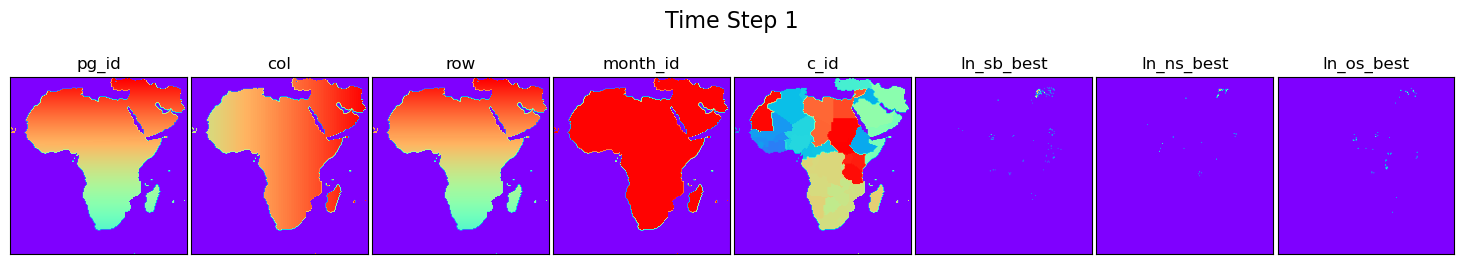

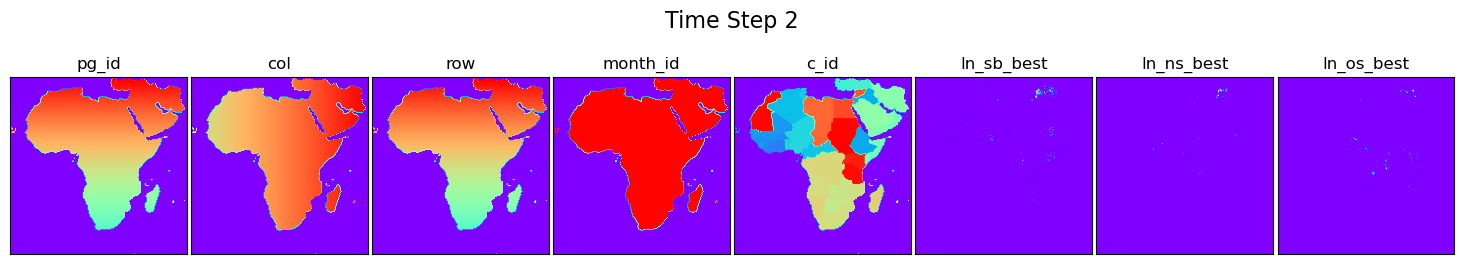

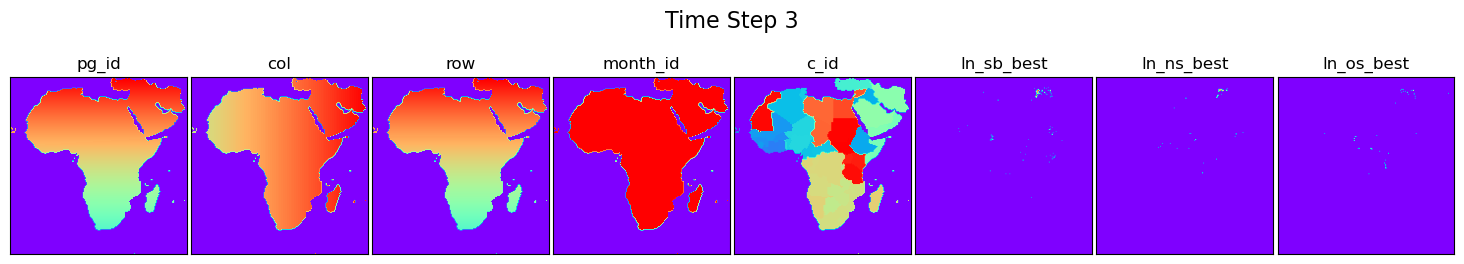

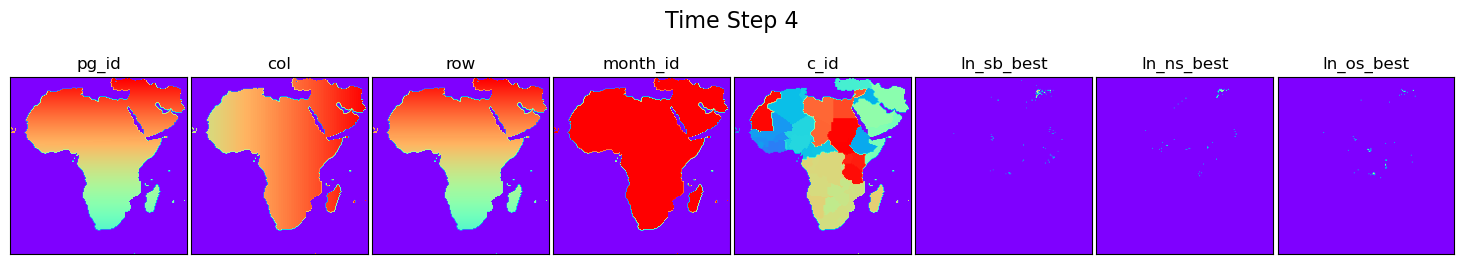

In [2]:
PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_df.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_conversion_test(df, vol)

plot_vol(vol, 4)

# Now...

# Then figure out the thing below with doing stuff without the ourput tensor... 

-----------------------------------------
# Stuff THAT WORKS!!!

Now it is basically about:
- take the bit loop below, and make sure it works for both eval and forecasing using the meta thing
- Also there should be a simple way to turn as out_put_dict into a metric dict... 
    - Can you think future output drift detection into this or is that completely seperate?
- Then package everything nice and neat
- Distribute to relevant/appropiate scripts
- Make sure to ubdate the eval rutine to corrospond
- Then implement the forecasting rutine... Finally. 


## old notes

## start reading here!!! :

This is the thing that need to be the fundament.
First I need to see that this works with the storage_array or another way of retaining or retreaving pg_id and month_id
One possible way to do this is by using the meta_tensor you have started on below
An alternative would be to to make a full full_tensor. I.e one that contains both the 3 prime feature and the "meta" fatures
Ones we have proven we can get month_id and pgm back we need to see a out-of-sampel solution where we go beyond what is in the df
And then I think we need to go back streamline the evaluation process so it follows. WHile doing so I must
    
- keep true forecasting firmly in the mind
- Think about what, if anything, can be abstracted out to common_utils for the sake of getting it right for the stepshifters - maybe wandb stuff
- And while ad it, make sure you use you new data class to store the monthly metrics -------------------------------------------------This now--------------------------
- The more you can absract out and make general, the simple it should be
- And while you add it, make sure to check if the partitions are the same as in paper. If they are, get the results down and finish paper.


# WHAT YOU ARE REALLY DOING:
- Aligning evaluation with forecasting to make a common appraoch
- MAke sure that logging and uploading (wandb) of metrics is consice and consitant
- Make sure that logging and uplaoding (predicion store and other?) os out outs from all partitions - whether true forecast or not - is consice and consistent
- You might want a data class thing of outputs (like the one uo have ofr metrics). Generel for all models forecsating conflict
- You want to make everythign as generel/abstract as possible - especially WandB stuff!!!

In [3]:
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36 # MAGIC NUMBER ALERT - this is the number of months in the future we are forecasting

# get the three lists from the posterior_dict - we make the out_of_sample_vol later
posterior_list, posterior_list_class, _ = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

In [4]:
# get the views_vol from the df
views_vol = df_to_vol(df)
views_vol = views_vol.copy() # why the fuck face this works I swear I have no idea

# get the full_tensor and the new meta_data:tendor
full_tensor, metadata_tensor = get_full_tensor(views_vol ) #, config, device) # better cal this evel tensor
print(views_vol.shape)

# Get the out of sample vol and the out of sampele meta_vol <---------------------------- THIS IS CENTRAL, BECAUSE TO REAL FORECASTING TO WORK YOU JUST NEED TO GEN A SYNTH out_of_sample_meta_vol
out_of_sample_vol = full_tensor[:,-month_range:,:,:,:] #.cpu().numpy() # From the test tensor get the out-of-sample time_steps.
out_of_sample_meta_vol = metadata_tensor[:,-month_range:,:,:,:]

print(out_of_sample_vol.shape)
print(out_of_sample_meta_vol.shape)

# Merge full_tensor and metadata_tensor along the feature dimension - just a test
full_t_new = np.concatenate((out_of_sample_meta_vol, out_of_sample_vol), axis=2)

print(f'Shape of merged tensor: {full_t_new.shape}') # lets trust that 

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
views_vol shape (324, 180, 180, 8)
full_tensor shape torch.Size([1, 324, 3, 180, 180])
(324, 180, 180, 8)
torch.Size([1, 36, 3, 180, 180])
torch.Size([1, 36, 5, 180, 180])
Shape of merged tensor: (1, 36, 8, 180, 180)


In [5]:
steps = 36
eval = True

# bad name if eval is an arguement.... evaluate_andor_forecast_posterior

#def evaluate_posterior(model, views_vol, config, device): # is eval in config?

#posterior_list, posterior_list_class, out_of_sample_vol, full_tensor, metadata_tensor = sample_posterior(model, views_vol, config, device)


if eval:
    dict_of_eval_dicts = {}
    dict_of_eval_dicts = {k: EvaluationMetrics.make_evaluation_dict(steps=steps) for k in ["sb", "ns", "os"]}

dict_of_outputs_dicts = {}
dict_of_outputs_dicts = {k: ModelOutputs.make_output_dict(steps=steps) for k in ["sb", "ns", "os"]}

# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

#NEW
log_dict_list = []
#feature_dict_list = []

for t in range(mean_array.shape[0]): #  0 of mean array is the temporal dim    
    
    log_dict = {}
    log_dict["monthly/out_sample_month"] = t +1 # 1 indexed, bc the first step is 1 month ahead

    for i, j in enumerate(dict_of_eval_dicts.keys()): # this is the same as the above but with the dict keys

        step = f"step{str(t+1).zfill(2)}"
        
        # get the scores
        y_score = mean_array[t,i,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[t,i,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[t,i,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[t,i,:,:].reshape(-1)  # nu 180x180 

        # see this is the out of sample vol - fine for evaluation but not for forecasting
        # but also the place where you get the pgm.. 

        if eval:
            y_true = out_of_sample_vol[:,t,i,:,:].numpy().reshape(-1)  # nu 180x180 . dim 0 is time     THE TRICK IS NOW TO USE A df -> vol and not out_of_sample_vol...
            y_true_binary = (y_true > 0) * 1

            # in theorty you could just use the metadata tensor to get pg and c id here
            pg_id = out_of_sample_meta_vol[:,t,0,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
            c_id = out_of_sample_meta_vol[:,t,4,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
            month_id = out_of_sample_meta_vol[:,t,3,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id

            dict_of_outputs_dicts[j][step].y_true = y_true
            dict_of_outputs_dicts[j][step].y_true_binary = y_true_binary

        else: # you need to make sure this works for forecasting
            # in theorty you could just use the metadata tensor to get pg and c id here
            pg_id = out_of_sample_meta_vol[:,t,0,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
            c_id = out_of_sample_meta_vol[:,t,4,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
            month_id = out_of_sample_meta_vol[:,t,3,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id


        dict_of_outputs_dicts[j][step].y_score = y_score
        dict_of_outputs_dicts[j][step].y_score_prob = y_score_prob
        dict_of_outputs_dicts[j][step].y_var = y_var
        dict_of_outputs_dicts[j][step].y_var_prob = y_var_prob

        dict_of_outputs_dicts[j][step].pg_id = pg_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].c_id = c_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].step = t +1 # 1 indexed, bc the first step is 1 month ahead
        dict_of_outputs_dicts[j][step].month_id = month_id

        if eval:   

            dict_of_eval_dicts[j][step].MSE = mean_squared_error(y_true, y_score)
            dict_of_eval_dicts[j][step].AP = average_precision_score(y_true_binary, y_score_prob)
            dict_of_eval_dicts[j][step].AUC = roc_auc_score(y_true_binary, y_score_prob)
            dict_of_eval_dicts[j][step].Brier = brier_score_loss(y_true_binary, y_score_prob)

            log_dict = generate_wandb_log_dict(log_dict, dict_of_eval_dicts, j, step)

    if eval:
        log_dict_list.append(log_dict)

In [6]:
dict_of_outputs_dicts['sb']['step01']

ModelOutputs(y_score=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), y_score_prob=array([0.02670701, 0.02389795, 0.01763119, ..., 0.02032852, 0.04520813,
       0.05064365], dtype=float32), y_var=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), y_var_prob=array([0.02365297, 0.00693422, 0.00843668, ..., 0.0078035 , 0.02004953,
       0.02159236], dtype=float32), y_true=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), y_true_binary=array([0, 0, 0, ..., 0, 0, 0]), pg_id=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), c_id=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), month_id=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), step=1)

In [7]:
df_sb = ModelOutputs.output_dict_to_dataframe(dict_of_outputs_dicts["sb"])


In [8]:
# reindex the df_sb but keep the old index ad a column month_out_of_sample
df_sb["month_out_of_sample"] = df_sb.index +1
df_sb = df_sb.reset_index(drop=True)
df_sb

,y_score,y_score_prob,y_var,y_var_prob,y_true,y_true_binary,pg_id,c_id,month_id,step,month_out_of_sample
0,0.0,0.026707,0.0,0.023653,0.0,0,0.0,0.0,0.0,1,1
1,0.0,0.023898,0.0,0.006934,0.0,0,0.0,0.0,0.0,1,1
2,0.0,0.017631,0.0,0.008437,0.0,0,0.0,0.0,0.0,1,1
3,0.0,0.011944,0.0,0.003927,0.0,0,0.0,0.0,0.0,1,1
4,0.0,0.014769,0.0,0.008357,0.0,0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1166395,0.0,0.018215,0.0,0.005211,0.0,0,0.0,0.0,0.0,36,36
1166396,0.0,0.0217,0.0,0.006203,0.0,0,0.0,0.0,0.0,36,36
1166397,0.0,0.020911,0.0,0.008755,0.0,0,0.0,0.0,0.0,36,36
1166398,0.0,0.035661,0.0,0.011362,0.0,0,0.0,0.0,0.0,36,36


In [9]:
df_full = output_to_df(dict_of_outputs_dicts)

In [10]:
print(average_precision_score(df_full["y_true_binary_sb"], df_full["y_score_prob_sb"]))
print(average_precision_score(df_full["y_true_binary_ns"], df_full["y_score_prob_ns"]))
print(average_precision_score(df_full["y_true_binary_os"], df_full["y_score_prob_os"]))

0.4852209300141229
0.17038775892604552
0.20029771002360147


In [11]:
df_full[['pg_id', 'c_id', 'step', 'month_id', 'y_true_sb', 'y_score_sb']]

,pg_id,c_id,step,month_id,y_true_sb,y_score_sb
0,190494.0,89.0,1,409,0.0,0.0
1,190495.0,89.0,1,409,0.0,0.0
2,190496.0,89.0,1,409,0.0,0.0
3,190507.0,96.0,1,409,0.0,0.0
4,190508.0,96.0,1,409,0.0,0.0
...,...,...,...,...,...,...
471955,80332.0,163.0,36,444,0.0,0.0
471956,79599.0,163.0,36,444,0.0,0.0
471957,79600.0,163.0,36,444,0.0,0.0
471958,79601.0,163.0,36,444,0.0,0.0


In [12]:
df_full[df_full['pg_id'] == 190494][['pg_id', 'c_id', 'step', 'month_id', 'y_true_sb', 'y_score_sb']]

,pg_id,c_id,step,month_id,y_true_sb,y_score_sb
0,190494.0,89.0,1,409,0.0,0.0
13110,190494.0,89.0,2,410,0.0,0.0
26220,190494.0,89.0,3,411,0.0,0.0
39330,190494.0,89.0,4,412,0.0,0.0
52440,190494.0,89.0,5,413,0.0,0.0
65550,190494.0,89.0,6,414,0.0,0.0
78660,190494.0,89.0,7,415,0.0,0.0
91770,190494.0,89.0,8,416,0.0,0.0
104880,190494.0,89.0,9,417,0.0,0.0
117990,190494.0,89.0,10,418,0.0,0.0


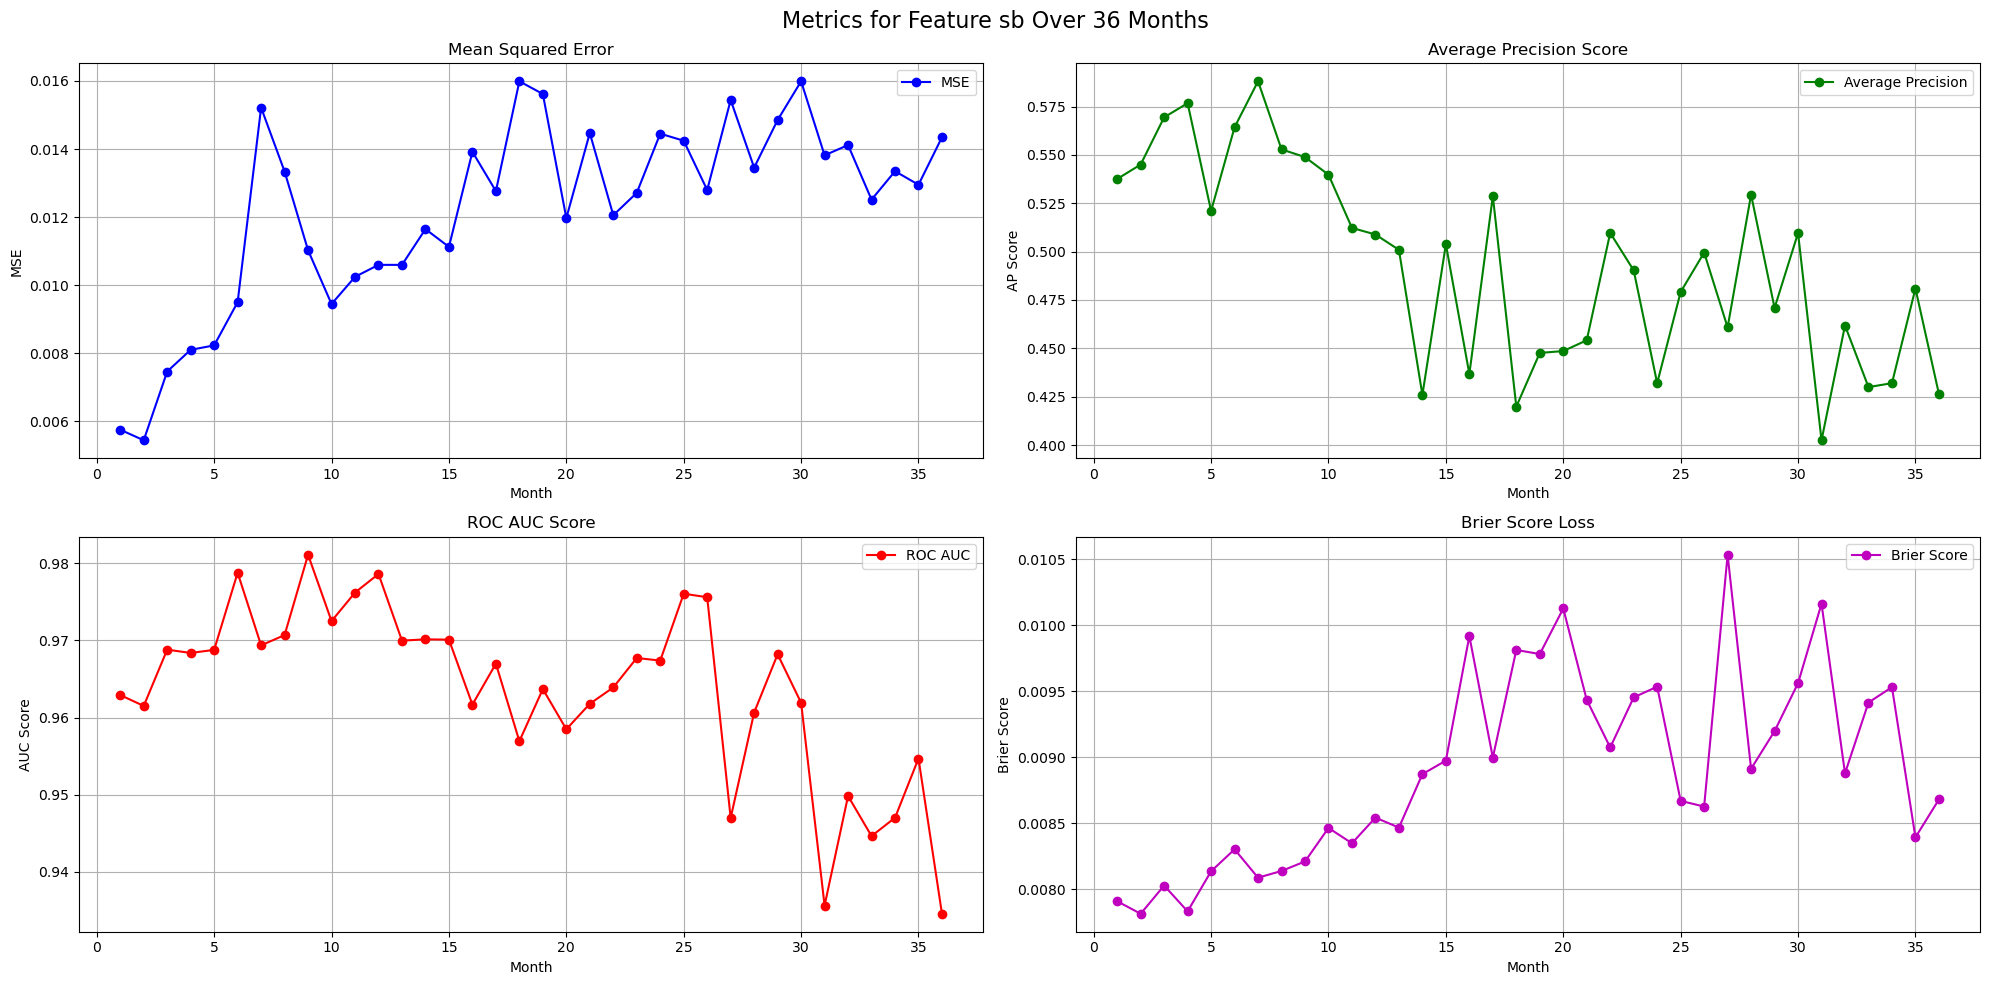

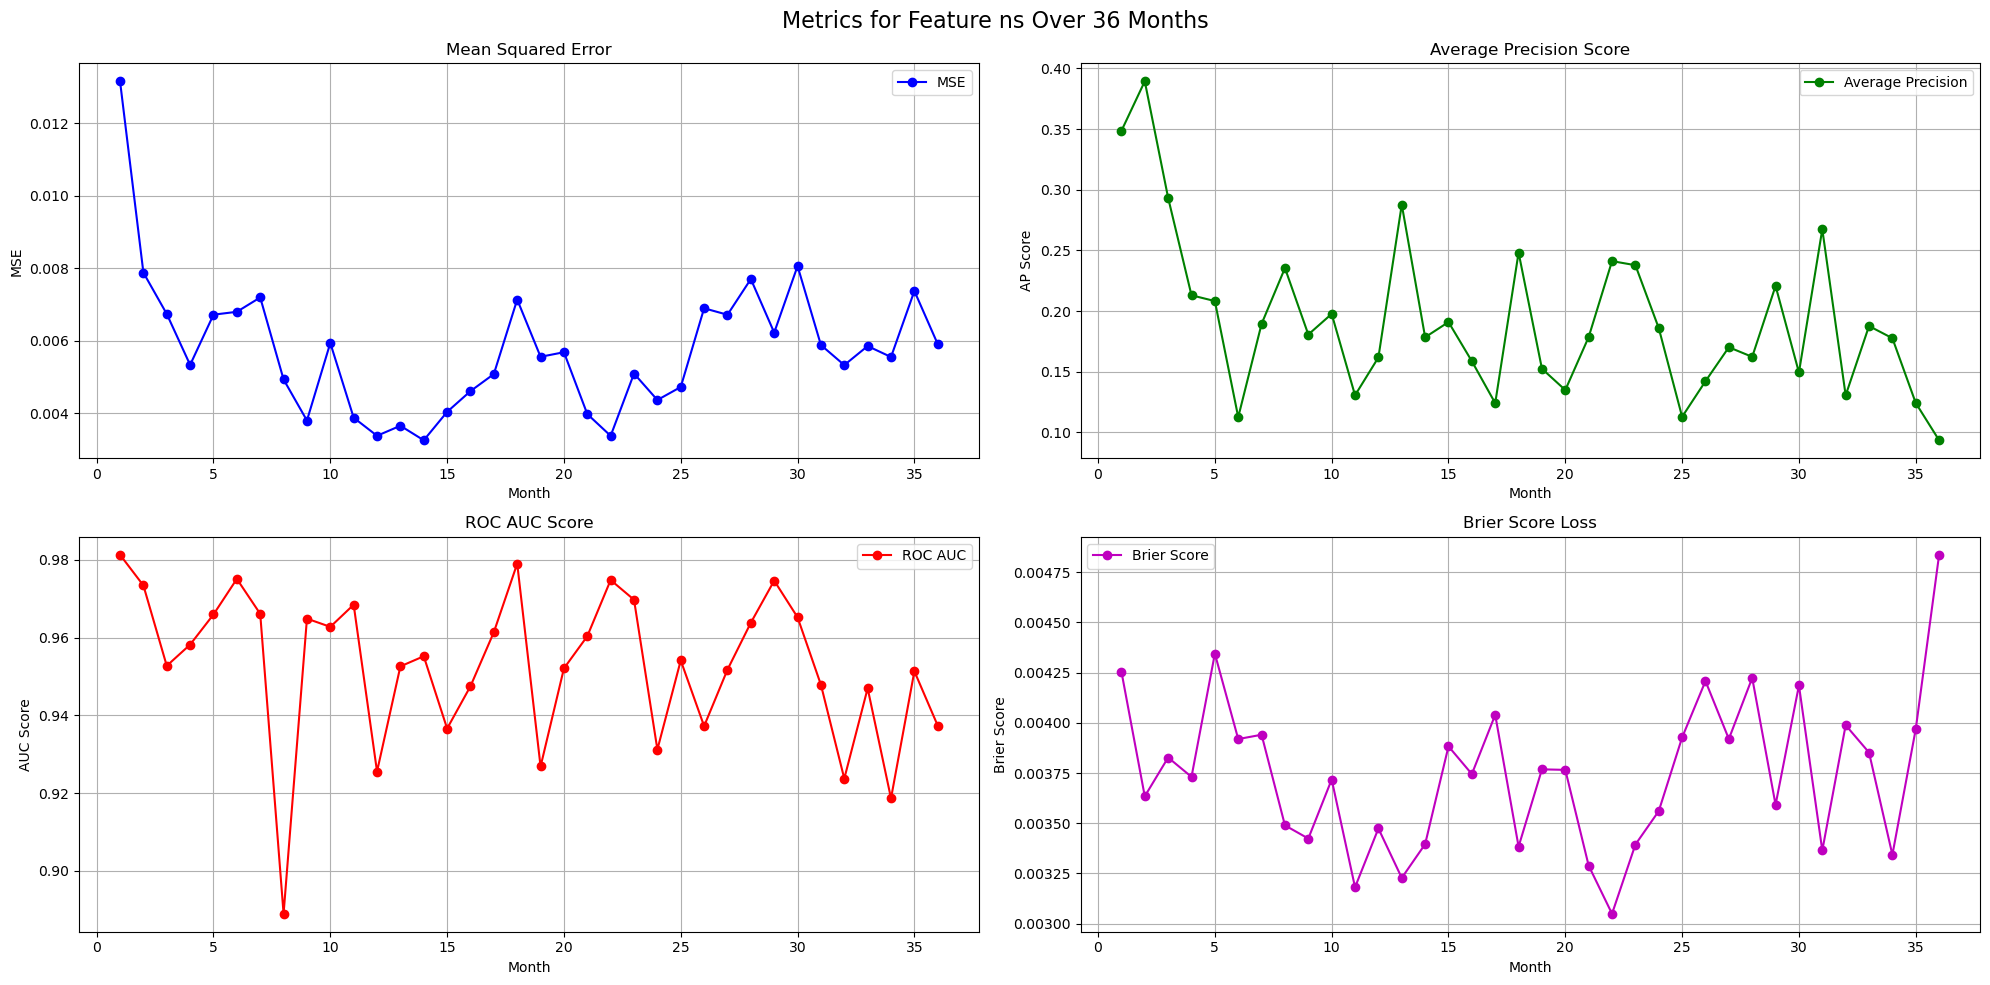

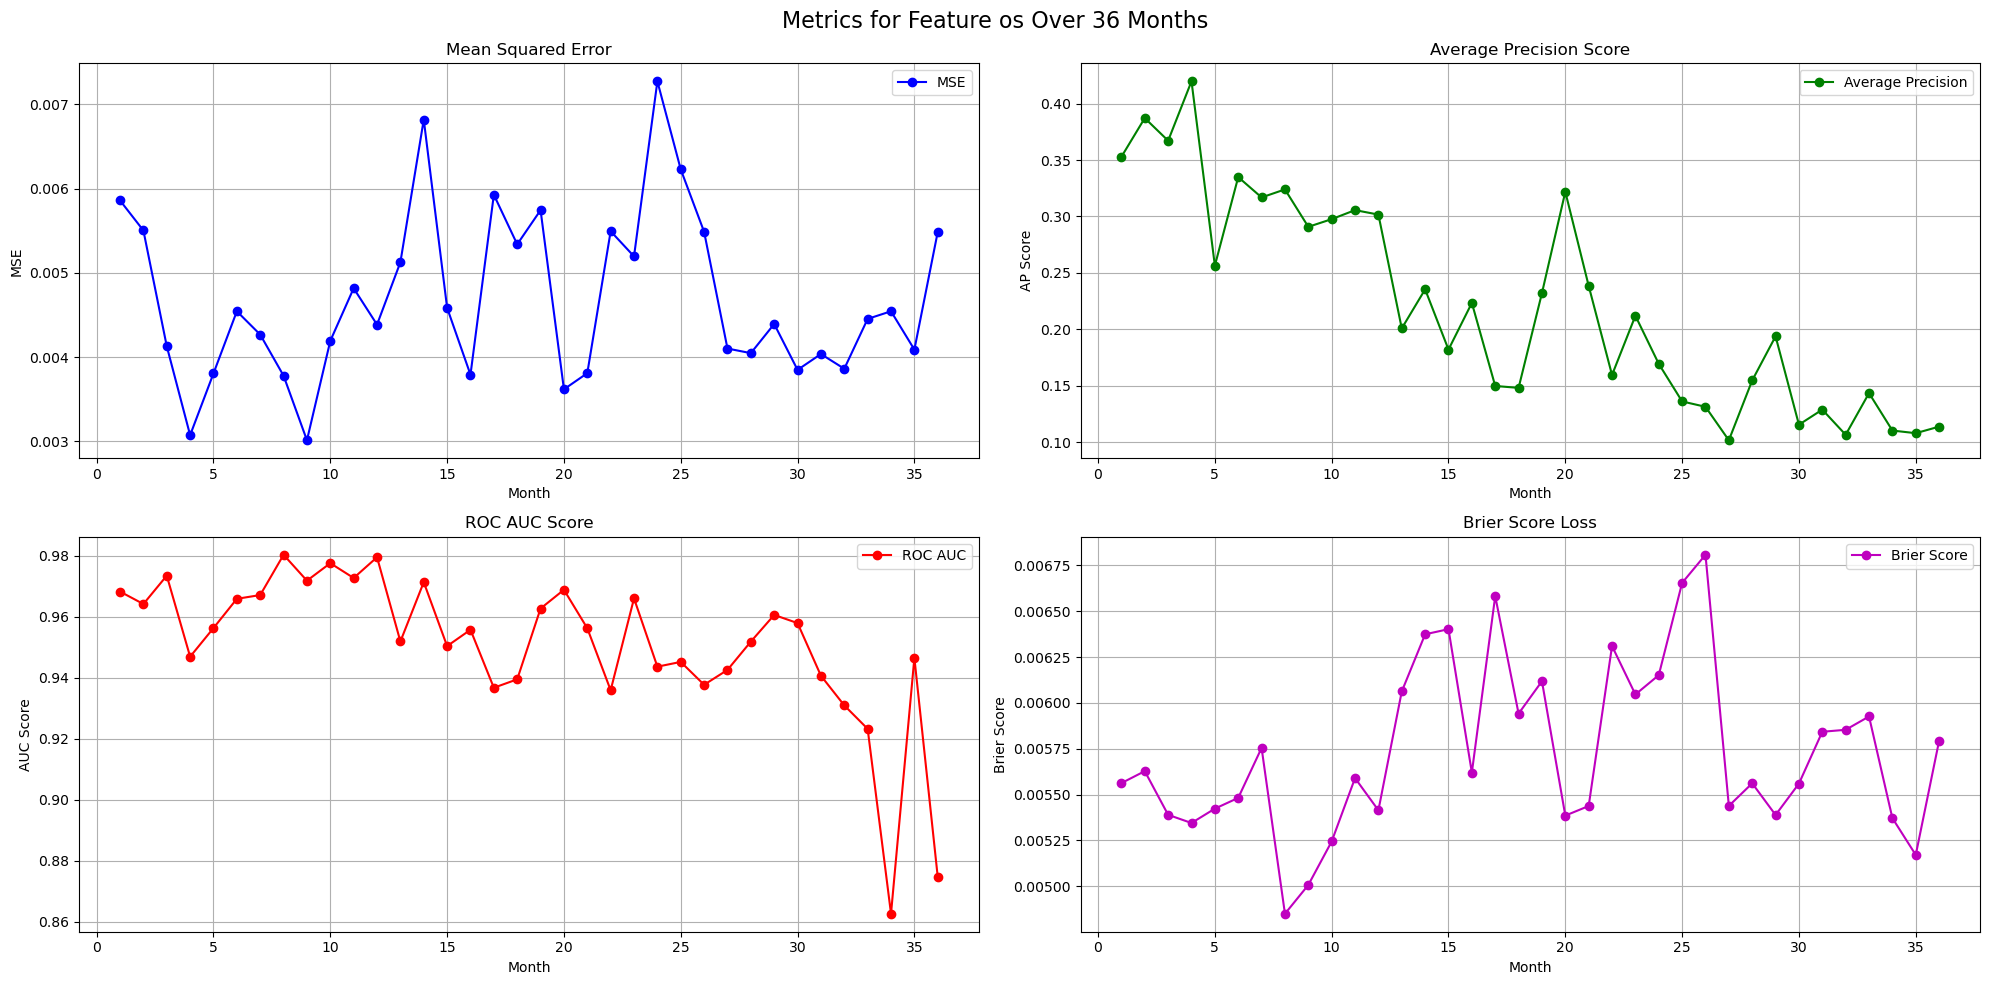

In [13]:
# Example usage:
plot_metrics(df_full, "sb")

# Example usage:
plot_metrics(df_full, "ns")

# Example usage:
plot_metrics(df_full, "os")

In [14]:
df_eval = evaluation_to_df(dict_of_eval_dicts)
df_eval

,MSE_sb,MAE_sb,MSLE_sb,KLD_sb,Jeffreys_sb,CRPS_sb,Brier_sb,AP_sb,AUC_sb,ensemble_weight_reg_sb,...,MAE_os,MSLE_os,KLD_os,Jeffreys_os,CRPS_os,Brier_os,AP_os,AUC_os,ensemble_weight_reg_os,ensemble_weight_class_os
step01,0.002328,None,None,None,None,None,0.003319,0.537134,0.982683,None,...,None,None,None,None,None,0.002306,0.352628,0.986393,None,None
step02,0.002202,None,None,None,None,None,0.003278,0.544482,0.982665,None,...,None,None,None,None,None,0.002332,0.386861,0.984097,None,None
step03,0.003020,None,None,None,None,None,0.003364,0.568834,0.986135,None,...,None,None,None,None,None,0.002234,0.366961,0.988708,None,None
step04,0.003278,None,None,None,None,None,0.003286,0.576274,0.985153,None,...,None,None,None,None,None,0.002216,0.419475,0.970713,None,None
step05,0.003330,None,None,None,None,None,0.003409,0.520463,0.986359,None,...,None,None,None,None,None,0.002247,0.256184,0.980823,None,None
step06,0.003844,None,None,None,None,None,0.003476,0.563772,0.990983,None,...,None,None,None,None,None,0.002271,0.334666,0.985144,None,None
step07,0.006157,None,None,None,None,None,0.003387,0.587456,0.986576,None,...,None,None,None,None,None,0.002381,0.316656,0.985827,None,None
step08,0.005398,None,None,None,None,None,0.003409,0.552313,0.987215,None,...,None,None,None,None,None,0.002015,0.323889,0.991910,None,None
step09,0.004461,None,None,None,None,None,0.003437,0.548346,0.992083,None,...,None,None,None,None,None,0.002078,0.290728,0.988102,None,None
step10,0.003822,None,None,None,None,None,0.003540,0.539163,0.988153,None,...,None,None,None,None,None,0.002174,0.297525,0.990478,None,None


# Now forecasting storage test
Now we test how we can make a storage array for the 4D forcast

### Functions

In [15]:
from utils_true_forecasting import generate_fake_vol, make_forecast_storage_vol, merge_vol, check_vol_equal, plot_vol_comparison

### Execute

In [16]:
month_range = 36

vol_fake = generate_fake_vol(vol, month_range=month_range)

#print shape of vol_fake
print(vol_fake.shape)

# make the forecast storage volume
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

#print shape of forecast_storage_vol
print(forecast_storage_vol.shape)

# merge the forecast storage volume with the forecast volume
new_vol = merge_vol(forecast_storage_vol, vol_fake)

#print shape of full_vol
print(new_vol.shape)

# Check that the full vol is equal to the original vol (sliced correctly)
check_vol_equal(vol, new_vol)

# plot the volume slices
# plot_vol_comparison(vol, new_vol, month_range=month_range) # works and cornfirms that the two volumes are the same (except for month_id, which is expected)

(36, 180, 180, 3)
Volume of shape (36, 180, 180, 5) created. Should be (36, 180, 180, 5)
(36, 180, 180, 5)
Volume of shape (36, 180, 180, 8) created. Should be (36, 180, 180, 8)
(36, 180, 180, 8)
(324, 180, 180, 8)
(36, 180, 180, 8)
(36, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True


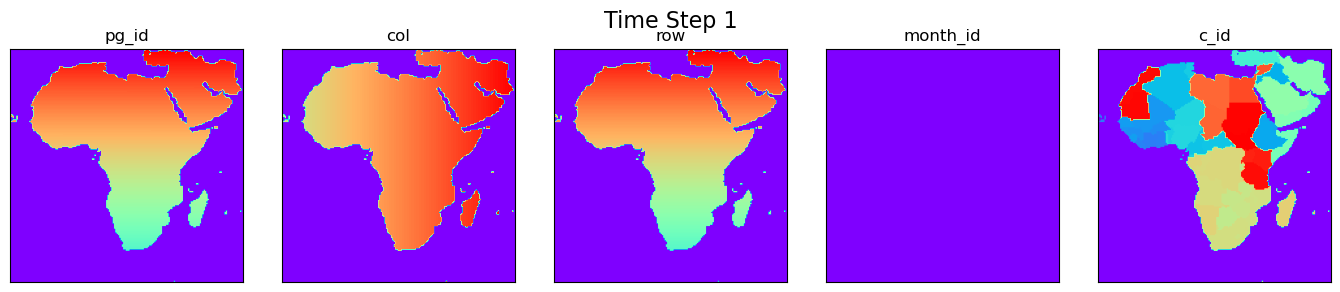

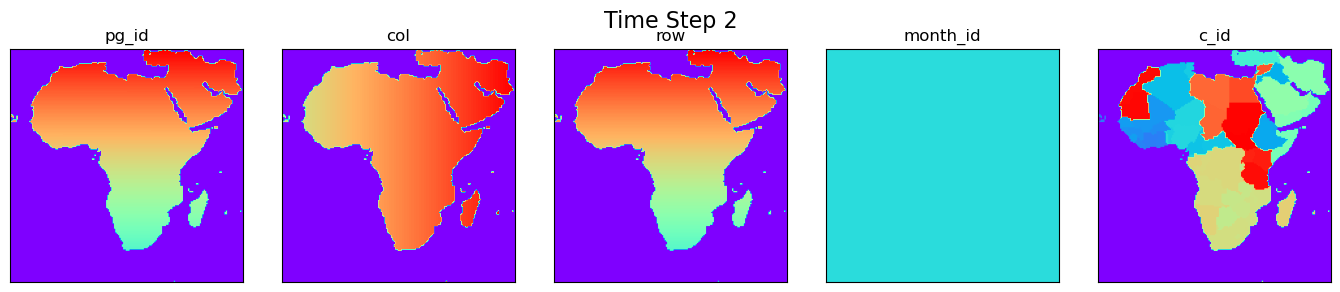

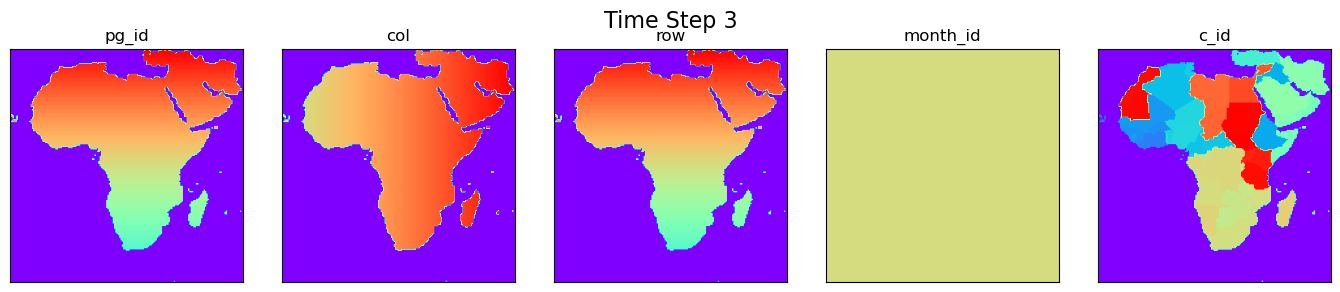

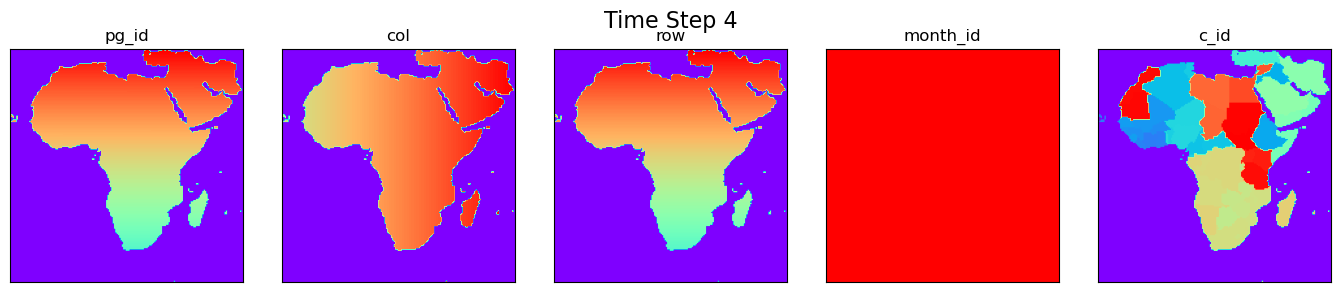

In [17]:
# plot the volume slices
plot_vol(forecast_storage_vol, 4)

# Now the forecasting loop

In [18]:
print(forecast_storage_vol.shape)
print(out_of_sample_meta_vol.shape)

forecast_storage_vol_new = torch.tensor(forecast_storage_vol.copy()).float().unsqueeze(dim=0).permute(0,1,4,2,3) # the copy thing is weird but it works
print(forecast_storage_vol_new.shape)

# print the min month_id
print(f'Min month_id: {forecast_storage_vol_new[:, :, 3, :, :].min()}')

# print the max month_id
print(f'Max month_id: {forecast_storage_vol_new[:, :, 3, :, :].max()}')

(36, 180, 180, 5)
torch.Size([1, 36, 5, 180, 180])
torch.Size([1, 36, 5, 180, 180])
Min month_id: 445.0
Max month_id: 480.0


In [19]:

# So need to check that you can sample posterior when running forecasting
#posterior_list, posterior_list_class, out_of_sample_vol, out_of_sample_meta_vol, full_tensor, metadata_tensor = sample_posterior(model, views_vol, config, device)


config = {'time_steps': 36, 'sweep': False}

dict_of_outputs_dicts = {}
dict_of_outputs_dicts = {k: ModelOutputs.make_output_dict(steps=config['time_steps']) for k in ["sb", "ns", "os"]}

# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)


for t in range(mean_array.shape[0]): #  0 of mean array is the temporal dim    

    for i, j in enumerate(dict_of_outputs_dicts.keys()): # this is the same as the above but with the dict keys

        step = f"step{str(t+1).zfill(2)}"

        # get the scores
        y_score = mean_array[t,i,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[t,i,:,:].reshape(-1) # nu 180x180 

        # do not really know what to do with these yet.
        y_var = std_array[t,i,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[t,i,:,:].reshape(-1)  # nu 180x180 

        # use the synth storage vol to get the pg_id, c_id, and month_id
        # the think is that you need to make sure that the metadata tensor is in the right order!!!!!!!!!!!!!!!!!!!!!
        # There need to be a test (even is you feel like you have tested the shit out of it in the notebook...)
        pg_id = forecast_storage_vol_new[:,t,0,:,:].reshape(-1)  # nu 180x180, dim 0 is batch, dim 1 is time . dim 2 is feature. feature 0 is pg_id
        c_id = forecast_storage_vol_new[:,t,4,:,:].reshape(-1)  # nu 180x180, dim 0 is batch, dim 1 is time . dim 2 is feature. feature 4 is c_id
        month_id = forecast_storage_vol_new[:,t,3,:,:].reshape(-1)  # nu 180x180, dim o is batch, dim 1 is time . dim 2 is feature. feature 3 is month_id

        dict_of_outputs_dicts[j][step].y_score = y_score
        dict_of_outputs_dicts[j][step].y_score_prob = y_score_prob
        dict_of_outputs_dicts[j][step].y_var = y_var
        dict_of_outputs_dicts[j][step].y_var_prob = y_var_prob

        dict_of_outputs_dicts[j][step].pg_id = pg_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].c_id = c_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].step = t +1 # 1 indexed, bc the first step is 1 month ahead
        dict_of_outputs_dicts[j][step].month_id = month_id

    posterior_dict = {'posterior_list' : posterior_list, 'posterior_list_class': posterior_list_class, 'out_of_sample_vol' : out_of_sample_vol}
#    save_model_outputs(PATH, config, posterior_dict, dict_of_outputs_dicts, dict_of_eval_dicts, full_tensor, metadata_tensor)

df_full = output_to_df(dict_of_outputs_dicts, forecast=True)
# drop "observed" columns
df_full = df_full.drop(columns=['y_true_sb', 'y_true_binary_sb', 'y_true_ns', 'y_true_binary_ns', 'y_true_os', 'y_true_binary_os'])

df_full

,y_score_sb,y_score_prob_sb,y_var_sb,y_var_prob_sb,y_score_ns,y_score_prob_ns,y_var_ns,y_var_prob_ns,y_score_os,y_score_prob_os,y_var_os,y_var_prob_os,pg_id,c_id,month_id,step
0,0.0,0.012501,0.0,0.008333,0.0,0.005774,0.0,0.003639,0.0,0.014164,0.0,0.010537,190494.0,89.0,445,1
1,0.0,0.018376,0.0,0.008886,0.0,0.007191,0.0,0.002927,0.0,0.012341,0.0,0.003757,190495.0,89.0,445,1
2,0.0,0.026849,0.0,0.008277,0.0,0.008907,0.0,0.004089,0.0,0.021944,0.0,0.008376,190496.0,89.0,445,1
3,0.0,0.008015,0.0,0.009268,0.0,0.004133,0.0,0.002773,0.0,0.006006,0.0,0.002231,190507.0,96.0,445,1
4,0.0,0.006838,0.0,0.003458,0.0,0.002705,0.0,0.001150,0.0,0.005918,0.0,0.003656,190508.0,96.0,445,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471955,0.0,0.004207,0.0,0.003358,0.0,0.000910,0.0,0.000628,0.0,0.002150,0.0,0.001037,80332.0,163.0,480,36
471956,0.0,0.007323,0.0,0.002956,0.0,0.002316,0.0,0.002725,0.0,0.002361,0.0,0.001647,79599.0,163.0,480,36
471957,0.0,0.003124,0.0,0.001822,0.0,0.001406,0.0,0.001155,0.0,0.003345,0.0,0.002142,79600.0,163.0,480,36
471958,0.0,0.006426,0.0,0.005848,0.0,0.002251,0.0,0.002238,0.0,0.002143,0.0,0.001696,79601.0,163.0,480,36


In [20]:
mean_array.shape

(36, 3, 180, 180)

In [23]:
forecast_storage_vol_new.squeeze().shape

torch.Size([36, 5, 180, 180])

In [37]:
t1 = mean_array
t2 = forecast_storage_vol_new.squeeze().numpy()

# merge t1 and t2 along the feature dimension
t_new = np.concatenate((t1, t2), axis=1)

# print the shape of t_new
print(t_new.shape)

# permute the dimensions of t_new
t_new = np.transpose(t_new, (0, 2, 3, 1))

# print the shape of t_new
print(t_new.shape)

(36, 8, 180, 180)
(36, 180, 180, 8)


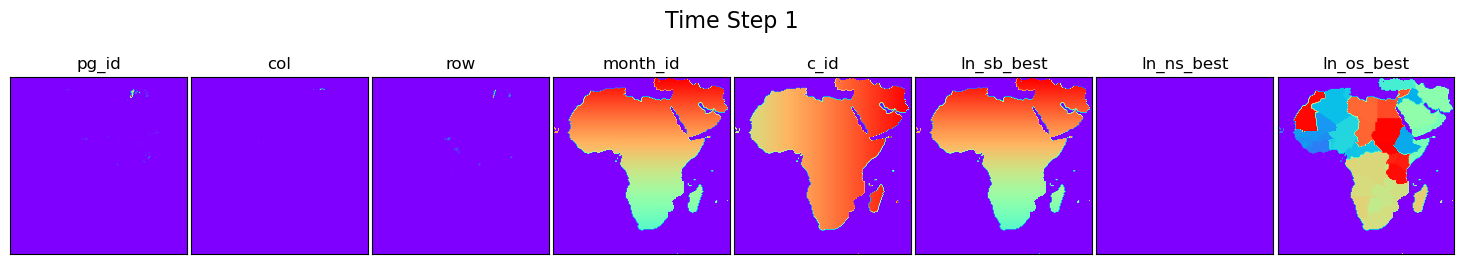

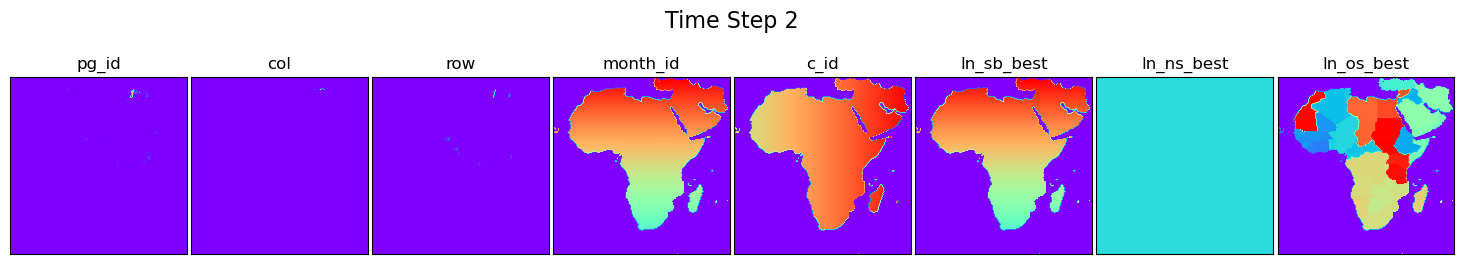

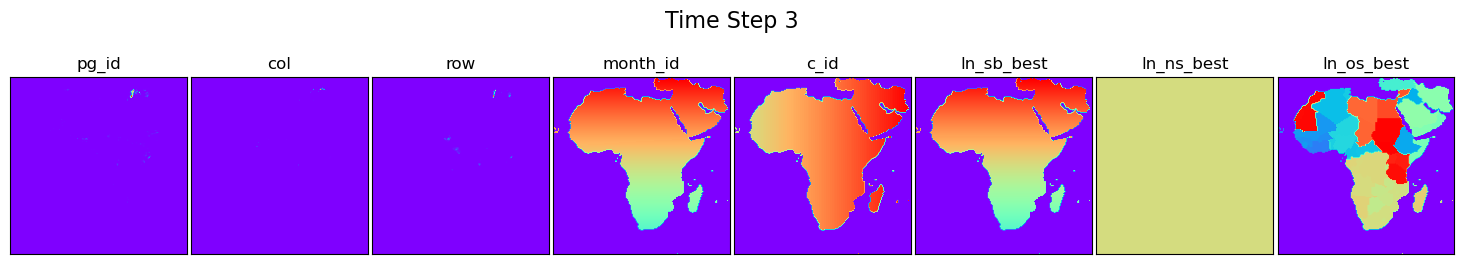

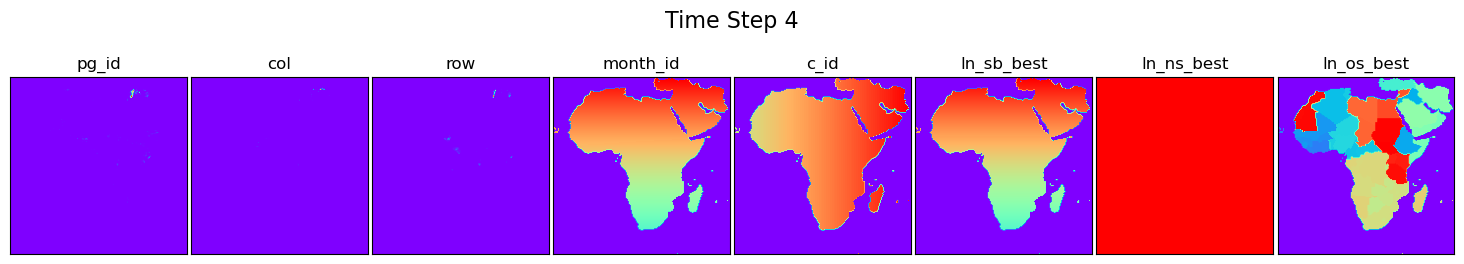

In [38]:
plot_vol(t_new, 4) # so obviously the title is wrong, but otherwise it works!!!! You did champo <3

# old but gold

In [ ]:
#posterior_list, posterior_list_class, out_of_sample_vol, out_of_sample_meta_vol, full_tensor, metadata_tensor = sample_posterior(model, views_vol, config, device)

# So need to check that you can sample posterior when running forecasting

config = {'time_steps': 36, 'sweep': False}

# if eval:
#dict_of_eval_dicts = {}
#dict_of_eval_dicts = {k: EvaluationMetrics.make_evaluation_dict(steps=config['time_steps']) for k in ["sb", "ns", "os"]}

dict_of_outputs_dicts = {}
dict_of_outputs_dicts = {k: ModelOutputs.make_output_dict(steps=config['time_steps']) for k in ["sb", "ns", "os"]}

# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)


for t in range(mean_array.shape[0]): #  0 of mean array is the temporal dim    
#    print(t)

#    log_dict = {}
#    log_dict["monthly/out_sample_month"] = t +1 # 1 indexed, bc the first step is 1 month ahead

    for i, j in enumerate(dict_of_outputs_dicts.keys()): # this is the same as the above but with the dict keys

        step = f"step{str(t+1).zfill(2)}"

        # get the scores
        y_score = mean_array[t,i,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[t,i,:,:].reshape(-1) # nu 180x180 

        # do not really know what to do with these yet.
        y_var = std_array[t,i,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[t,i,:,:].reshape(-1)  # nu 180x180 

        # see this is the out of sample vol - fine for evaluation but not for forecasting
        # but also the place where you get the pgm.. 

        #if eval:
        #y_true = out_of_sample_vol[:,t,i,:,:].reshape(-1)  # nu 180x180 . dim 0 is time     THE TRICK IS NOW TO USE A df -> vol and not out_of_sample_vol...
        #y_true_binary = (y_true > 0) * 1

        # in theorty you could just use the metadata tensor to get pg and c id here
        # pg_id = out_of_sample_meta_vol[:,t,0,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
        # c_id = out_of_sample_meta_vol[:,t,4,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
        # month_id = out_of_sample_meta_vol[:,t,3,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id

        # use the synth storage vol to get the pg_id, c_id, and month_id
        # the think is that you need to make sure that the metadata tensor is in the right order!!!!!!!!!!!!!!!!!!!!!
        # There need to be a test (even is you feel like you have tested the shit out of it in the notebook...)
        pg_id = forecast_storage_vol_new[:,t,0,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
        c_id = forecast_storage_vol_new[:,t,4,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
        month_id = forecast_storage_vol_new[:,t,3,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id

        # So, using the metadata tensor, you can get the pg_id, c_id, and month_id for each prediction.
        # It is similar to the out_of_sample_meta_vol, but not the specific subset of months
        # What you of course need is the extent the metadata tensor 36 months ahead in time on the right dimensions
        # But then you good, right?

        # if eval
#        dict_of_outputs_dicts[j][step].y_true = y_true
#        dict_of_outputs_dicts[j][step].y_true_binary = y_true_binary
#
#        #else: # you need to make sure this works for forecasting
#            # in theorty you could just use the metadata tensor to get pg and c id here
#        pg_id = out_of_sample_meta_vol[:,t,0,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
#        c_id = out_of_sample_meta_vol[:,t,4,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
#        month_id = out_of_sample_meta_vol[:,t,3,:,:].reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id
#
        dict_of_outputs_dicts[j][step].y_score = y_score
        dict_of_outputs_dicts[j][step].y_score_prob = y_score_prob
        dict_of_outputs_dicts[j][step].y_var = y_var
        dict_of_outputs_dicts[j][step].y_var_prob = y_var_prob

        dict_of_outputs_dicts[j][step].pg_id = pg_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].c_id = c_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].step = t +1 # 1 indexed, bc the first step is 1 month ahead
        dict_of_outputs_dicts[j][step].month_id = month_id

        # if eval:   
        # dict_of_eval_dicts[j][step].MSE = mean_squared_error(y_true, y_score)
        # dict_of_eval_dicts[j][step].AP = average_precision_score(y_true_binary, y_score_prob)
        # dict_of_eval_dicts[j][step].AUC = roc_auc_score(y_true_binary, y_score_prob)
        #dict_of_eval_dicts[j][step].Brier = brier_score_loss(y_true_binary, y_score_prob)

        # note that this actually upates the dict of eval dicts with new stepwise metric values
        # log_dict = generate_wandb_log_dict(log_dict, dict_of_eval_dicts, j, step)

    # if eval:
    # wandb.log(log_dict)

# mean_metric_log_dict = generate_wandb_mean_metrics_log_dict(dict_of_eval_dicts)
# wandb.log(mean_metric_log_dict)

#if not config.sweep:

    posterior_dict = {'posterior_list' : posterior_list, 'posterior_list_class': posterior_list_class, 'out_of_sample_vol' : out_of_sample_vol}
#    save_model_outputs(PATH, config, posterior_dict, dict_of_outputs_dicts, dict_of_eval_dicts, full_tensor, metadata_tensor)

#else:
#    print('Running sweep. NO posterior dict, metric dict, or test vol pickled+dumped')


df_full = output_to_df(dict_of_outputs_dicts, forecast=True)
df_full

In [ ]:
df

In [ ]:
# re-permute the forecast storage vol
forecast_storage_vol_old = forecast_storage_vol_new.permute(0,1,3,4,2).squeeze(dim=0).numpy()
print(forecast_storage_vol_old.shape)

In [ ]:
# and plot the volume slices
plot_vol(forecast_storage_vol_old, 4)

So we can now construct the vol form a df, and we can reconstruct the df from the vol. We can also make a forecasting storage and merge that with (fake) predictions to get a vol similar to the original vol. Now must take that back to a df. 

# new_vol to df

Now, create a new vol and make into a df and ceck that this df can corrospond to the original df

In [ ]:
# Lets start from scracth
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
df = pd.read_pickle(PATH)

vol = df_to_vol(df)

vol_fake = generate_fake_vol(vol, month_range=month_range)

forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

new_vol = merge_vol(forecast_storage_vol, vol_fake)

check_vol_equal(vol, new_vol)

df_new = vol_to_df(new_vol)

In [ ]:
print(df["month_id"].max())
(df_new["month_id"].min())


In [ ]:
df_new

In [ ]:
month_range = 36
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

# only keep the features that are in the new volume
df_sub = df_sub[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

df_sub 

In [ ]:
# now sort both dataframes by pg_id and month_id
df_sub = df_sub.sort_values(by=['pg_id', 'month_id'])
df_new = df_new.sort_values(by=['pg_id', 'month_id'])

# check which columns are not equal 
for i in range(df_sub.shape[1]):
    print(f"Feature {i}, {df_sub.columns[i]} equal:", np.array_equal(df_sub.iloc[:, i], df_new.iloc[:, i]))

Looking good. Now we need to add actual predictions instead of "fake_predictions" which were just the last subset of observations. 

# posterior dict to vol to df...
Load the correct posterio_dict and the original df (you could prolly use the saved vol, but fuck it)

### functions
just some small changes to the functions above

In [ ]:
def vol_to_df_new(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_pred': vol[:, :, :, 5].flatten(),
        'ln_ns_pred': vol[:, :, :, 6].flatten(),
        'ln_os_pred': vol[:, :, :, 7].flatten(),
        'proba_os_pred': vol[:, :, :, 8].flatten(),
        'proba_ns_pred': vol[:, :, :, 9].flatten(),
        'proba_sb_pred': vol[:, :, :, 10].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [ ]:
def vol_to_df_oos(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best_oos': vol[:, :, :, 5].flatten(),
        'ln_ns_best_oos': vol[:, :, :, 6].flatten(),
        'ln_os_best_oos': vol[:, :, :, 7].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df

In [ ]:
# lets start from scratch again

PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36 # but what even is it in the partion by now?

In [ ]:
# get the three lists from the posterior_dict
posterior_list, posterior_list_class, out_of_sample_vol = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

# the posterior_list is a list of list of arrays
# the first list is the number of draws from the posterior
# the second list is the number of months in the forecast
# the arrays are the forecasted volumes for size 3x180x180

In [ ]:
# maybe you can just use a modfication of this loop to make the df?

# IMPORTANT!!!

So, see if you can make a df from this - remember two things: 
- you don't have an out_of_sample_vol for true forecasts. 
- And out_of_sample_vol also don't have any features beyond history of violence..  

So this is to a large extent a validation execice we need to see if we can:
- turn it back into a df
- get the same results as with the get_log_dict
- Anf then figure out how to get the same resultes with the df of vol... 

In [ ]:
def get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol):

    """Return a dictionary of metrics for the monthly out-of-sample predictions for W&B."""

    log_dict = {}
    log_dict["monthly/out_sample_month"] = i


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier


    return log_dict

In [ ]:
# OKAY! lets start with the thing from eval
# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

out_sample_month_list = [] # only used for pickle...
ap_list = []
mse_list = []
auc_list = []
brier_list = []

#NEW
log_dict_list = []

for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

    #y_score = mean_array[i].reshape(-1) # make it 1d  # nu 180x180
    #y_score_prob = mean_class_array[i].reshape(-1) # nu 180x180

    # do not really know what to do with these yet.
#    y_var = std_array[i].reshape(-1)  # nu 180x180
#    y_var_prob = std_class_array[i].reshape(-1)  # nu 180x180

#    y_true = out_of_sample_vol[:,i].reshape(-1)  # nu 180x180 . dim 0 is time
 #   y_true_binary = (y_true > 0) * 1
#
    # log the metrics to WandB - but why here? 
    log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol)# so at least it gets reported sep.
    log_dict_list.append(log_dict)

    #wandb.log(log_dict)

    # YOU KNOW THIS IS WRONG ALREADY!!!!

#    # this could be a function in utils_wandb or in common_utils... 
#    mse = mean_squared_error(y_true, y_score)  
#    ap = average_precision_score(y_true_binary, y_score_prob)
#    auc = roc_auc_score(y_true_binary, y_score_prob)
#    brier = brier_score_loss(y_true_binary, y_score_prob)
#
#    out_sample_month_list.append(i) # only used for pickle...
#    mse_list.append(mse)
#    ap_list.append(ap) # add to list.
#    auc_list.append(auc)
#    brier_list.append(brier)
#

In [ ]:
def plot_metrics(log_dict_list, num_months, feature = 0):
    """
    Plots MSE, Average Precision, ROC AUC, and Brier Score for each month from log_dict_list.

    Args:
        log_dict_list (list of dict): List of dictionaries with monthly metrics.
        num_months (int): Number of months to plot.
    """

    # Initialize lists to store metrics for each month
    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    # Iterate over the log_dict_list and extract the metrics
    for i in range(num_months):
        mse_list.append(log_dict_list[i][f'monthly/mean_squared_error{feature}'])
        ap_list.append(log_dict_list[i][f'monthly/average_precision_score{feature}'])
        auc_list.append(log_dict_list[i][f'monthly/roc_auc_score{feature}'])
        brier_list.append(log_dict_list[i][f'monthly/brier_score_loss{feature}'])

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Plot MSE
    axs[0, 0].plot(range(1, len(mse_list) + 1), mse_list, marker='o', color='b', label='MSE')
    axs[0, 0].set_title('Mean Squared Error')
    axs[0, 0].set_xlabel('Month')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Average Precision
    axs[0, 1].plot(range(1, len(ap_list) + 1), ap_list, marker='o', color='g', label='Average Precision')
    axs[0, 1].set_title('Average Precision Score')
    axs[0, 1].set_xlabel('Month')
    axs[0, 1].set_ylabel('AP Score')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot ROC AUC
    axs[1, 0].plot(range(1, len(auc_list) + 1), auc_list, marker='o', color='r', label='ROC AUC')
    axs[1, 0].set_title('ROC AUC Score')
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('AUC Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot Brier Score
    axs[1, 1].plot(range(1, len(brier_list) + 1), brier_list, marker='o', color='m', label='Brier Score')
    axs[1, 1].set_title('Brier Score Loss')
    axs[1, 1].set_xlabel('Month')
    axs[1, 1].set_ylabel('Brier Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # add a title
    plt.suptitle(f'Metrics for Feature {feature} Over {num_months} Months', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()


# Example usage:
plot_metrics(log_dict_list, 36, 0)

# Example usage:
plot_metrics(log_dict_list, 36, 1)

# Example usage:
plot_metrics(log_dict_list, 36, 2)


In [ ]:
def get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol):

    """Return a dictionary of metrics for the monthly out-of-sample predictions for W&B."""

    log_dict = {}
    log_dict["monthly/out_sample_month"] = i


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier


    return log_dict

-----------------------------------------
# SHIT THAT WORKS!!!
## start reading here!!! :

This is the thing that need to be the fundament.
First I need to see that this works with the storage_array or another way of retaining or retreaving pg_id and month_id
One possible way to do this is by using the meta_tensor you have started on below
An alternative would be to to make a full full_tensor. I.e one that contains both the 3 prime feature and the "meta" fatures
Ones we have proven we can get month_id and pgm back we need to see a out-of-sampel solution where we go beyond what is in the df
And then I think we need to go back streamline the evaluation process so it follows. WHile doing so I must
    
    - keep true forecasting firmly in the mind
    - Think about what, if anything, can be abstracted out to common_utils for the sake of getting it right for the stepshifters - maybe wandb stuff
    - And while ad it, make sure you use you new data class to store the monthly metrics
    - The more you can absract out and make general, the simple it should be
    - And while you add it, make sure to check if the partitions are the same as in paper. If they are, get the results down and finish paper.

In [ ]:
# lets start from scratch again

PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_df.pkl"
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36

# get the three lists from the posterior_dict - we make the out_of_sample_vol later
posterior_list, posterior_list_class, _ = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

In [ ]:

def get_full_tensor(views_vol): #, config, device):

    """Uses to get the features for the full tensor
    Used for out-of-sample predictions for both evaluation and forecasting, depending on the run_type (partition). 
    The test tensor is of size 1 x config.time_steps x config.input_channels x 180 x 180."""

    ln_best_sb_idx = 5#config.first_feature_idx # 5 = ln_best_sb
    last_feature_idx = ln_best_sb_idx + month_range #config.input_channels

    print(f'views_vol shape {views_vol.shape}')

    # THIS IS WHERE YOU LOOSE THE OTHE FEATURES!!!!
    full_tensor = torch.tensor(views_vol).float().unsqueeze(dim=0).permute(0,1,4,2,3)[:, :, ln_best_sb_idx:last_feature_idx, :, :] 

    # Make a metadata tensor with evrything else
    metadata_tensor = torch.tensor(views_vol).float().unsqueeze(dim=0).permute(0,1,4,2,3)[:, :, :ln_best_sb_idx, :, :]

    print(f'full_tensor shape {full_tensor.shape}')

    return full_tensor 

In [ ]:
views_vol = df_to_vol(df)
views_vol = views_vol.copy() # why the fuck face this works I swear I have no idea

print(views_vol.shape)

In [ ]:
full_tensor = get_full_tensor(views_vol ) #, config, device) # better cal this evel tensor

#out_of_sample_vol = full_tensor[:,-config.time_steps:,:,:,:].cpu().numpy() # From the test tensor get the out-of-sample time_steps. 
out_of_sample_vol = full_tensor[:,-month_range:,:,:,:] #.cpu().numpy() # From the test tensor get the out-of-sample time_steps.



In [ ]:
# OKAY! lets start with the thing from eval
# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

out_sample_month_list = [] # only used for pickle...
ap_list = []
mse_list = []
auc_list = []
brier_list = []

#NEW
log_dict_list = []
feature_dict_list = []

for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

    # log the metrics to WandB - but why here? 
    #log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol)# so at least it gets reported sep.
    
    
    log_dict = {}
    log_dict["monthly/out_sample_month"] = i

    feature_dict = {}


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time     THE TRICK IS NOW TO USE A df -> vol and not out_of_sample_vol...
        y_true_binary = (y_true > 0) * 1

        # data
        feature_dict[f"y_score{j}"] = y_score
        feature_dict[f"y_score_prob{j}"] = y_score_prob
        feature_dict[f"y_var{j}"] = y_var
        feature_dict[f"y_var_prob{j}"] = y_var_prob
        feature_dict[f"y_true{j}"] = y_true
        feature_dict[f"y_true_binary{j}"] = y_true_binary

        # metrics
        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier
    
    
    
    feature_dict_list.append(feature_dict)
    log_dict_list.append(log_dict)




In [ ]:
df_test2 = pd.DataFrame.from_dict(feature_dict_list).apply(pd.Series.explode)

# reset the index and keep the old index as a column month
df_test2 = df_test2.reset_index().rename(columns = {"index": "month"})

df_test2 # we don't konw if the month order is correct yet... But I highly suspect that it is.

In [ ]:
# check all datatyps in columns
df_test2.dtypes

# change all columns to float
df_test2 = df_test2.astype(float)

# check all datatyps in columns
df_test2.dtypes

# make the binary columns integers
df_test2 = df_test2.astype({"y_true_binary0": int, "y_true_binary1": int, "y_true_binary2": int})

# check all datatyps in columns
df_test2.dtypes

In [ ]:
print(average_precision_score(df_test2["y_true_binary0"], df_test2["y_score_prob0"]))
print(average_precision_score(df_test2["y_true_binary1"], df_test2["y_score_prob1"]))
print(average_precision_score(df_test2["y_true_binary2"], df_test2["y_score_prob2"]))

In [ ]:
# okay so this works... lest recreat the monthly metrics for all features and the plot from above

def plot_metrics(df_test2, feature = 0):

    """
    Plots MSE, Average Precision, ROC AUC, and Brier Score for each month from log_dict_list.

    Args:
        log_dict_list (list of dict): List of dictionaries with monthly metrics.
        num_months (int): Number of months to plot.
    """

    # Initialize lists to store metrics for each month
    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []


    # Iterate over the log_dict_list and extract the metrics
    for i in df_test2["month"].unique():

        y_score = df_test2[df_test2["month"] == i][f"y_score{feature}"]
        y_score_prob = df_test2[df_test2["month"] == i][f"y_score_prob{feature}"]
        y_true = df_test2[df_test2["month"] == i][f"y_true{feature}"]
        y_true_binary = df_test2[df_test2["month"] == i][f"y_true_binary{feature}"]

        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)


        mse_list.append(mse)
        ap_list.append(ap)
        auc_list.append(auc)
        brier_list.append(brier)

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Plot MSE
    axs[0, 0].plot(range(1, len(mse_list) + 1), mse_list, marker='o', color='b', label='MSE')
    axs[0, 0].set_title('Mean Squared Error')
    axs[0, 0].set_xlabel('Month')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Average Precision
    axs[0, 1].plot(range(1, len(ap_list) + 1), ap_list, marker='o', color='g', label='Average Precision')
    axs[0, 1].set_title('Average Precision Score')
    axs[0, 1].set_xlabel('Month')
    axs[0, 1].set_ylabel('AP Score')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot ROC AUC
    axs[1, 0].plot(range(1, len(auc_list) + 1), auc_list, marker='o', color='r', label='ROC AUC')
    axs[1, 0].set_title('ROC AUC Score')
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('AUC Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot Brier Score
    axs[1, 1].plot(range(1, len(brier_list) + 1), brier_list, marker='o', color='m', label='Brier Score')
    axs[1, 1].set_title('Brier Score Loss')
    axs[1, 1].set_xlabel('Month')
    axs[1, 1].set_ylabel('Brier Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # add a title
    plt.suptitle(f'Metrics for Feature {feature} Over {df_test2["month"].max()} Months', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()


# Example usage:
plot_metrics(df_test2, 0)

# Example usage:
plot_metrics(df_test2, 1)

# Example usage:
plot_metrics(df_test2, 2)



In [ ]:
df_test = df.from_dict(log_dict_list)
df_test 

### Shit that works is right above

-------------------------------------------------------------------------

In [ ]:
# Trynna make the df this style
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
#std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
#std_class_array = np.array(posterior_list_class).std(axis = 0)


#dict_features = {}

df_features = pd.DataFrame()

for j in range(3):
#for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim. you could use an actual month_id array here

#    print(i)

#    dict_features[j] = {}

    y_score_list = []
    y_score_prob_list = []
    y_true_list = []
    y_true_binary_list = []
    month_list  = []

    #for j in range(3): # 3 features
    for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

        y_score_list.append(mean_array[i,j,:,:].reshape(-1)) # make it 1d  # nu 180x180
        y_score_prob_list.append(mean_class_array[i,j,:,:].reshape(-1)) # nu 180x180
        y_true_list.append(out_of_sample_vol[:,i,j,:,:].reshape(-1))  # nu 180x180 . dim 0 is time
        y_true_binary_list.append((y_true > 0) * 1)

        # month of same size as y_score_list

        if j == 0: # only do this once
            month_list.append(np.array([i]*len(y_score_list[i])))

    # lets go straight to df
    if j == 0:
        df_features[f'month'] = np.concatenate(month_list)
    
    df_features[f'y_score_{j}'] = np.concatenate(y_score_list)
    df_features[f'y_score_prob_{j}'] = np.concatenate(y_score_prob_list)
    df_features[f'y_true_{j}'] = np.concatenate(y_true_list)
    df_features[f'y_true_binary_{j}'] = np.concatenate(y_true_binary_list)
    



#    dict_features[j]["y_score"] = y_score_list
#   dict_features[j]["y_score_prob"] = y_score_prob_list
#    dict_features[j]["y_true"] = y_true_list
#    dict_features[j]["y_true_binary"] = y_true_binary_list
#    dict_features[j]["month"] = month_list

    # and now month so just i in and array the right size
    #dict_features[j]['month'] = np.array([i]*len(y_score_list[0])) # just make it the right size


# now the dict to df



In [ ]:
df_features

In [ ]:
average_precision_score(df_features[df_features['month'] == 0]['y_true_binary_1'], df_features[df_features['month'] == 0]['y_score_prob_1'])

In [ ]:
# firts feature 0,1, or 2. them the output type - y_score, y_score_prob, y_true, y_true_binary. then the month and then the 180x180 array

month_array = np.array(dict_features[0]["month"]).reshape(-1)
y_score_array_0 = np.array(dict_features[0]["y_score"]).reshape(-1)
y_score_prob_array_0 = np.array(dict_features[0]["y_score_prob"]).reshape(-1)
y_true_array_0 = np.array(dict_features[0]["y_true"]).reshape(-1)
y_true_binary_array_0 = np.array(dict_features[0]["y_true_binary"]).reshape(-1)

y_score_array_1 = np.array(dict_features[1]["y_score"]).reshape(-1)
y_score_prob_array_1 = np.array(dict_features[1]["y_score_prob"]).reshape(-1)
y_true_array_1 = np.array(dict_features[1]["y_true"]).reshape(-1)
y_true_binary_array_1 = np.array(dict_features[1]["y_true_binary"]).reshape(-1)

y_score_array_2 = np.array(dict_features[2]["y_score"]).reshape(-1)
y_score_prob_array_2 = np.array(dict_features[2]["y_score_prob"]).reshape(-1)
y_true_array_2 = np.array(dict_features[2]["y_true"]).reshape(-1)
y_true_binary_array_2 = np.array(dict_features[2]["y_true_binary"]).reshape(-1)

df_features = pd.DataFrame({
    'month_id': month_array,
    'y_score_0': y_score_array_0,
    'y_score_prob_0': y_score_prob_array_0,
    'y_true_0': y_true_array_0,
    'y_true_binary_0': y_true_binary_array_0,
    'y_score_1': y_score_array_1,
    'y_score_prob_1': y_score_prob_array_1,
    'y_true_1': y_true_array_1,
    'y_true_binary_1': y_true_binary_array_1,
    'y_score_2': y_score_array_2,
    'y_score_prob_2': y_score_prob_array_2,
    'y_true_2': y_true_array_2,
    'y_true_binary_2': y_true_binary_array_2,
})

df_features

In [ ]:
average_precision_score(df_features["y_true_binary_0"], df_features["y_score_prob_0"])

In [ ]:
# now get the monthly metrics for each feature in the df

for i in df_features["month_id"].unique():
    print(i)
    df_month = df_features[df_features["month_id"] == i]

    for j in range(3):
        y_score = df_month[f"y_score_{j}"]
        y_score_prob = df_month[f"y_score_prob_{j}"]
        y_true = df_month[f"y_true_{j}"]
        y_true_binary = df_month[f"y_true_binary_{j}"]

        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        print(f"Feature {j} - MSE: {mse}, AP: {ap}, AUC: {auc}, Brier: {brier}")



In [ ]:
# change the posterior_list to a numpy array of shape (n_draws, n_months, 3, 180, 180)
posterior_array = np.array(posterior_list)
print(posterior_array.shape)

# revesr the order of the months
posterior_array = np.flip(posterior_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_mean = np.mean(posterior_array, axis=0)
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_mean = np.transpose(posterior_mean, (0, 2, 3, 1))
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# and for class
posterior_class_array = np.array(posterior_list_class)
print(posterior_class_array.shape)

# revesr the order of the months
#posterior_class_array = np.flip(posterior_class_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_class_mean = np.mean(posterior_class_array, axis=0)
print(posterior_class_mean.shape)

# reverse the order of the months   
#posterior_class_mean = np.flip(posterior_class_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_class_mean = np.transpose(posterior_class_mean, (0, 2, 3, 1))
print(posterior_class_mean.shape)


In [ ]:
# concatenate the posterior_mean and the posterior_class_mean
posterior_all_mean = np.concatenate([posterior_mean, posterior_class_mean], axis=-1)

# reverse the order of the months
#posterior_all_mean = np.flip(posterior_all_mean, axis = 0)

print(posterior_all_mean.shape)

In [ ]:
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

In [ ]:
new_vol = merge_vol(forecast_storage_vol, posterior_all_mean)

In [ ]:
# what if we merge with the out_of_sample_vol instead?

# remove batch dimension from out_of_sample_vol
out_of_sample_vol_nb = np.squeeze(out_of_sample_vol, axis=0)

# reshape the out_of_sample_vol_nb to be similar to the vol
out_of_sample_vol_nb = np.transpose(out_of_sample_vol_nb, (0, 2, 3, 1))

#merge the out_of_sample_vol_nb with the forecast_storage_vol
new_vol_oos = merge_vol(forecast_storage_vol, out_of_sample_vol_nb)

In [ ]:
#plot_vol(new_vol, 3)
plot_vol(new_vol_oos, 3)

In [ ]:
df_new = vol_to_df_new(new_vol)
df_new_oos = vol_to_df_oos(new_vol_oos)

In [ ]:
df_new['month_id'].max()    

In [ ]:
# so the correctly the df_new have all months_ids moved forward. But since the evaluation set is here part of the original df, I'll just push it back to the original month_ids
df_new["month_id"] = df_new["month_id"] - month_range
print(df_new["month_id"].max())
df_new

In [ ]:
# now subset the df to only include the last month_range months
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

print(df_sub['month_id'].max())

df_sub

In [ ]:
# how does that compare the df_new_oos

# you need to take the month_id back to the oriringal month_id
df_new_oos["month_id"] = df_new_oos["month_id"] - month_range
df_new_oos["month_id"].max()

In [ ]:
# create a new df (df_merged) which is df_new but with ln_sb_best, ln_ns_best, ln_os_best from df_sub merged by pg_id and month_id

# real
#df_merged = df_new.merge(df_sub[['pg_id', 'month_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']], on=['pg_id', 'month_id'], how='left')

# oos
df_merged = df_new.merge(df_new_oos[['pg_id', 'month_id', 'ln_sb_best_oos', 'ln_ns_best_oos', 'ln_os_best_oos']], on=['pg_id', 'month_id'], how='left')

df_merged

In [ ]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
#df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

df_merged[['ln_sb_best_oos', 'ln_ns_best_oos', 'ln_os_best_oos', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

In [ ]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

In [ ]:


# binarize the ln's
# class_sb_best = df_merged['ln_sb_best'] > 0
# class_ns_best = df_merged['ln_ns_best'] > 0
# class_os_best = df_merged['ln_os_best'] > 0


# binarize the ln's
class_sb_best = df_merged['ln_sb_best_oos'] > 0
class_ns_best = df_merged['ln_ns_best_oos'] > 0
class_os_best = df_merged['ln_os_best_oos'] > 0

# get the auroc for the probas
auroc_sb = roc_auc_score(class_sb_best, df_merged['proba_sb_pred'])
auroc_ns = roc_auc_score(class_ns_best, df_merged['proba_ns_pred'])
auroc_os = roc_auc_score(class_os_best, df_merged['proba_os_pred'])

# get the average precision for the probas
ap_sb = average_precision_score(class_sb_best, df_merged['proba_sb_pred'])
ap_ns = average_precision_score(class_ns_best, df_merged['proba_ns_pred'])
ap_os = average_precision_score(class_os_best, df_merged['proba_os_pred'])

# get the brier score for the probas
brier_sb = brier_score_loss(class_sb_best, df_merged['proba_sb_pred'])
brier_ns = brier_score_loss(class_ns_best, df_merged['proba_ns_pred'])
brier_os = brier_score_loss(class_os_best, df_merged['proba_os_pred'])

# get the mse for the ln's
mse_sb = mean_squared_error(df_merged['ln_sb_best_oos'], df_merged['ln_sb_pred'])
mse_ns = mean_squared_error(df_merged['ln_ns_best_oos'], df_merged['ln_ns_pred'])
mse_os = mean_squared_error(df_merged['ln_os_best_oos'], df_merged['ln_os_pred'])

# create a nice table with all the results
results = pd.DataFrame({
    'auroc': [auroc_sb, auroc_ns, auroc_os],
    'ap': [ap_sb, ap_ns, ap_os],
    'brier': [brier_sb, brier_ns, brier_os],
    'mse': [mse_sb, mse_ns, mse_os]
}, index=['sb', 'ns', 'os'])

results

But you are not even sure if the querysets are the same... Should be but are you 100%?

In [ ]:
# check how that corropsonds to is we use the out_of_sample_vol

# remove the batch dimension
out_of_sample_vol_no_batch = out_of_sample_vol[0]

# reshape the out_of_sample_vol_no_batch to be similar to the vol
out_of_sample_vol_no_batch = np.transpose(out_of_sample_vol_no_batch, (0, 2, 3, 1))
print(out_of_sample_vol_no_batch.shape)

# now compare this to the 48 month of the vol
vol_3_36 = vol[-month_range:, :, :, 5:]
print(vol_3_36.shape)

# compare the two
print(np.array_equal(out_of_sample_vol_no_batch, vol_3_36))

# but are they near?
print(np.allclose(out_of_sample_vol_no_batch, vol_3_36))


In [ ]:
# but is there any correlation between the out_of_sample_vol and the vol_3_48?

# get the corr between the two arrays
print(np.corrcoef(out_of_sample_vol_no_batch.flatten(), vol_3_36.flatten()))


In [ ]:
# what is we forst sum each to see the total sum of the arrays and then substrat one from the other to see what the difference is
print(np.sum(out_of_sample_vol_no_batch))
print(np.sum(vol_3_36))

print(np.sum(out_of_sample_vol_no_batch) - np.sum(vol_3_36)) # Just a rounding error it seems. 

In [ ]:
# plot placehodlers for the two arrays

In [ ]:
# and now month specific metrics..

# first create the list to store the individaul monthly metrics

#auroc
auroc_sb_list = []
auroc_ns_list = []
auroc_os_list = []

#ap
ap_sb_list = []
ap_ns_list = []
ap_os_list = []

#brier
brier_sb_list = []
brier_ns_list = []
brier_os_list = []

#mse
mse_sb_list = []
mse_ns_list = []
mse_os_list = []

month_array = df_merged['month_id'].unique()
#print(month_array)

# loop through the months
for i in month_array:
    #print(i)

    # subset the df_merged to only include the month
    df_sub = df_merged[df_merged['month_id'] == i]

    # binarize the ln's for auroc, ap and brier
    #class_sb_best = df_sub['ln_sb_best'] > 0
    #class_ns_best = df_sub['ln_ns_best'] > 0
    #class_os_best = df_sub['ln_os_best'] > 0

    # binarize the ln's for auroc, ap and brier
    class_sb_best = df_sub['ln_sb_best_oos'] > 0
    class_ns_best = df_sub['ln_ns_best_oos'] > 0
    class_os_best = df_sub['ln_os_best_oos'] > 0

    # get the auroc for the probas and append to the list
    auroc_sb_list.append(roc_auc_score(class_sb_best, df_sub['proba_sb_pred']))
    auroc_ns_list.append(roc_auc_score(class_ns_best, df_sub['proba_ns_pred']))
    auroc_os_list.append(roc_auc_score(class_os_best, df_sub['proba_os_pred']))

    # get the average precision for the probas and append to the list
    ap_sb_list.append(average_precision_score(class_sb_best, df_sub['proba_sb_pred']))
    ap_ns_list.append(average_precision_score(class_ns_best, df_sub['proba_ns_pred']))
    ap_os_list.append(average_precision_score(class_os_best, df_sub['proba_os_pred']))

    # get the brier score for the probas and append to the list
    brier_sb_list.append(brier_score_loss(class_sb_best, df_sub['proba_sb_pred']))
    brier_ns_list.append(brier_score_loss(class_ns_best, df_sub['proba_ns_pred']))
    brier_os_list.append(brier_score_loss(class_os_best, df_sub['proba_os_pred']))

    # get the mse for the ln's and append to the list
    #mse_sb_list.append(mean_squared_error(df_sub['ln_sb_best'], df_sub['ln_sb_pred']))
    #mse_ns_list.append(mean_squared_error(df_sub['ln_ns_best'], df_sub['ln_ns_pred']))
    #mse_os_list.append(mean_squared_error(df_sub['ln_os_best'], df_sub['ln_os_pred']))

    # get the mse for the ln's and append to the list
    mse_sb_list.append(mean_squared_error(df_sub['ln_sb_best_oos'], df_sub['ln_sb_pred']))
    mse_ns_list.append(mean_squared_error(df_sub['ln_ns_best_oos'], df_sub['ln_ns_pred']))
    mse_os_list.append(mean_squared_error(df_sub['ln_os_best_oos'], df_sub['ln_os_pred']))

# create a nice table with all the results
results_month = pd.DataFrame({
    'auroc_sb': auroc_sb_list,
    'auroc_ns': auroc_ns_list,
    'auroc_os': auroc_os_list,
    'ap_sb': ap_sb_list,
    'ap_ns': ap_ns_list,
    'ap_os': ap_os_list,
    'brier_sb': brier_sb_list,
    'brier_ns': brier_ns_list,
    'brier_os': brier_os_list,
    'mse_sb': mse_sb_list,
    'mse_ns': mse_ns_list,
    'mse_os': mse_os_list,
    'moonth_id': month_array
}, index=month_array)

results_month

In [ ]:
# plot the 3 aps
plt.figure(figsize=(10, 5))

plt.plot(results_month['moonth_id'], results_month['ap_sb'], label='sb')
plt.plot(results_month['moonth_id'], results_month['ap_ns'], label='ns')
plt.plot(results_month['moonth_id'], results_month['ap_os'], label='os')

plt.legend()
plt.show()

# they are recognizably when compared to the WandB but distintly worse... 

So currently I can know if this is right... You need a posterior dict from fimbultuhul which is also evaluation on wieghts and biases